In [1]:
import BOX_1 as B
import numpy as np
import matplotlib.pyplot as plt

In [2]:
step_tot = 10**7
check_step = 1000

In [3]:
box = B.BOX(128,210,0.,0.,[2.5,0.],0.1)
av_c_size = np.zeros(check_step,dtype=float)
acceptance = list()
for n_steps in range(check_step):
    moves = np.array(box.monte_carlo_steps(step_tot//check_step))
    acceptance.append(np.where(moves==True)[0].shape[0]/step_tot/check_step)
    av_c_size[n_steps] = np.mean(box.cluster_size())

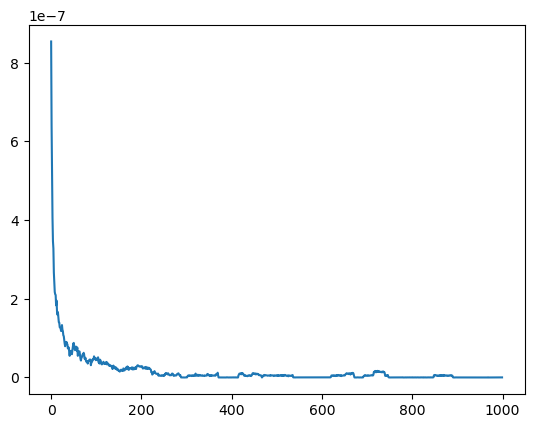

In [4]:
plt.plot(acceptance)

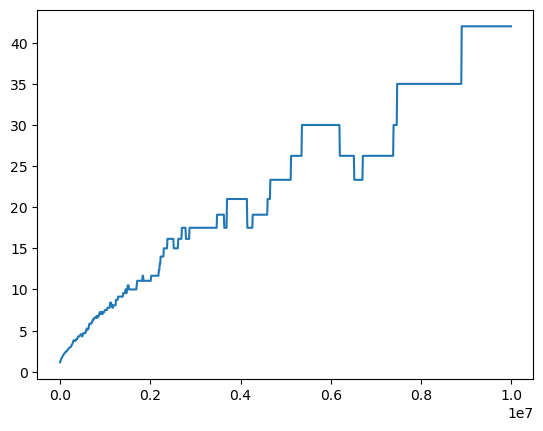

In [6]:
plt.plot([i*(step_tot//check_step) for i in range(check_step)],av_c_size)

In [7]:
box.cluster_size()

array([29, 44, 66, 13, 58])

In [9]:
import numpy as np
import MC_frontend
step_tot = 10**7
check_step = 10


In [25]:
mc = MC_frontend.MC(128,210,10,20,[[0.,0.,0.],[0.,0.,2.],[0.,2.,0.]],1.,0.1)
av_c_size = np.zeros(check_step,dtype=float)
acceptance = list()
for n_steps in range(check_step):
    print(n_steps)
    moves = np.array(mc.monte_carlo_steps(step_tot//check_step))
    acceptance.append(np.where(moves==True)[0].shape[0]/step_tot/check_step)
    av_c_size[n_steps] = np.mean(mc.get_cluster_size())

polymer successfully generated
particles successfully added
0
1
2
3
4
5
6
7
8
9


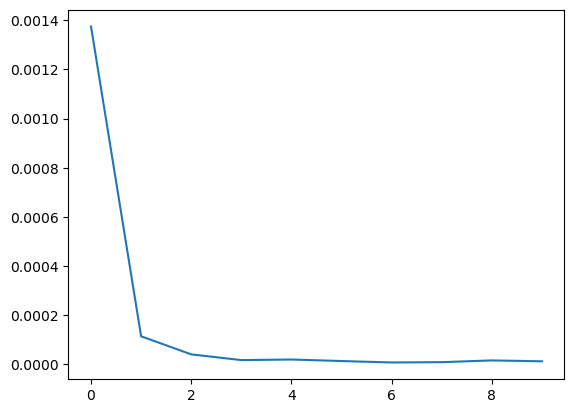

In [26]:
plt.plot(acceptance)

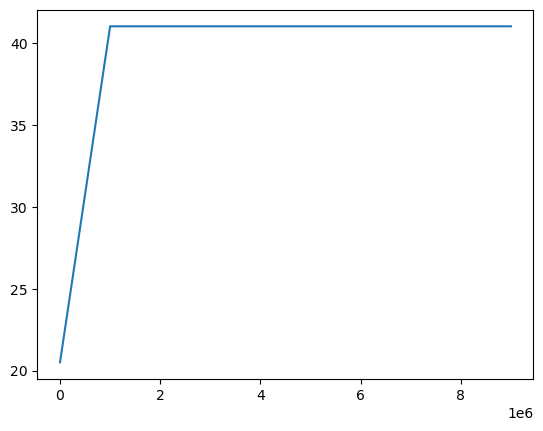

In [27]:
plt.plot([i*(step_tot//check_step) for i in range(check_step)],av_c_size)

In [28]:
mc.get_cluster_size()

array([41, 44, 43, 39, 34, 43, 43, 39, 41, 43])

In [22]:
import pyvista as pv
def plot_simulation(mc, output_filename='simulation.html'):
    size = mc.size

    # Get DHH1 positions and convert to coordinates
    dhh1_positions = mc.get_DHH1_positions()
    dhh1_coords = np.array([to_xyz(pos, size) for pos in dhh1_positions])

    # Get RNA positions and convert to coordinates
    rna_positions_list = mc.get_RNA_positions()
    rna_coords_list = []
    for rna_positions in rna_positions_list:
        coords = np.array([to_xyz(pos, size) for pos in rna_positions])
        rna_coords_list.append(coords)

    # Generate lattice vertices
    lattice_vertices = generate_lattice_vertices(size)

    # Create a PyVista plotter
    plotter = pv.Plotter()

    # Add the box contour as a light black wireframe cube
    box_center = (size / 2 - 0.5, size / 2 - 0.5, size / 2 - 0.5)
    box = pv.Cube(center=box_center, x_length=size, y_length=size, z_length=size)
    plotter.add_mesh(box, color='black', opacity=0.2, style='wireframe', line_width=1)

    # Add lattice vertices as small black dots
    #lattice_points = pv.PolyData(lattice_vertices)
    #plotter.add_mesh(lattice_points, color='black', point_size=2.5, render_points_as_spheres=True)

    # Add DHH1 particles as points
    if dhh1_coords.size > 0:
        dhh1_points = pv.PolyData(dhh1_coords)
        plotter.add_mesh(dhh1_points, color='red', point_size=10.0, render_points_as_spheres=True)

    # Plot RNA polymers as segments
    for coords in rna_coords_list:
        if coords.size > 0:
            # Initialize lists to store line segments
            segments = []
            num_monomers = coords.shape[0]
            for i in range(-num_monomers+1,num_monomers - 1):
                p1 = coords[i]
                p2 = coords[i + 1]

                # Unwrap positions to account for periodic boundary conditions
                delta = p2 - p1
                for dim in range(3):
                    if delta[dim] > size / 2:
                        delta[dim] -= size
                    elif delta[dim] < -size / 2:
                        delta[dim] += size
                p2_unwrapped = p1 + delta

                # Check if the segment crosses the boundary
                if np.any(p2_unwrapped < 0) or np.any(p2_unwrapped > size - 1):
                    # Clip the segment at the box boundaries
                    clipped_segment = clip_segment_to_box(p1, p2_unwrapped, size)
                    if clipped_segment is not None:
                        segments.append(clipped_segment)
                else:
                    # Segment is inside the box, add it directly
                    segments.append(np.array([p1, p2_unwrapped]))
            # Plot the segments
            for segment in segments:
                line = pv.Line(segment[0], segment[1])
                plotter.add_mesh(line, color='blue', line_width=2)

            # Also add monomer points
            monomer_points = pv.PolyData(coords)
            plotter.add_mesh(monomer_points, color='blue', point_size=20.0, render_points_as_spheres=True)

    # Set plotter options
    plotter.set_background('white')
    plotter.show_axes()
    plotter.show_bounds(
    grid='front',          # Show grid on the front face
    location='outer',      # Place labels outside the bounding box
    all_edges=True,        # Show all edges of the grid
    xtitle='X Axis',       # Label for the X-axis
    ytitle='Y Axis',       # Label for the Y-axis
    ztitle='Z Axis'        # Label for the Z-axis
    )
    # Optional: Set the camera position
    plotter.view_isometric()

    # Save the plot as an HTML file
    plotter.export_html(output_filename)
def to_xyz(index, size):
    z = index % size
    y = (index // size) % size
    x = index // (size * size)
    return np.array([x, y, z])
def generate_lattice_vertices(size):
    # Generate all combinations of x, y, z in 0..size-1
    x = np.arange(size)
    y = np.arange(size)
    z = np.arange(size)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    grid_points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
    return grid_points

In [29]:
MC_frontend.plot_simulation(mc)